In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import multiprocessing

2024-05-05 16:10:37.117565: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 16:10:37.117693: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 16:10:37.119467: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-05 16:10:37.129661: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 16:10:38.889154: W tensorflow/compiler/tf2

In [2]:
root_path = os.path.abspath('./')
print(root_path)
# In Google colab it must be /content. Feel free to comment out the following two lines.
assert root_path == '/notebooks'
root_path = '/notebooks'

/notebooks


In [3]:
! pip install datasets transformers[torch] sentencepiece

In [4]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.4.1).
0 upgraded, 0 newly installed, 0 to remove and 100 not upgraded.


In [5]:
import uuid
download_uuid=str(uuid.uuid4())
download_uuid

'49ce941b-794e-4ced-a0ec-8ce0a597c5a4'

In [6]:
!curl -o dragon-data.tar.gz https://drive.usercontent.google.com/download?id=14vFdqZDoD5WVrh2DIVKj_QL5RGLZe1fn&confirm=t&uuid={download_uuid}

In [7]:
# To have deterministic/reproducible training
# By the way, it's a wish! it doesn't work!
tf.keras.utils.set_random_seed(65464)
tf.config.experimental.enable_op_determinism()

In [8]:
os.chdir(root_path)
!rm -rf jim/dragon
!mkdir -p jim/dragon/{train,valid,test}/{dragon,notdragon}

In [9]:
os.chdir(root_path)
!tar -xzvf dragon-data.tar.gz -C jim/dragon/

data/
data/dragon/
data/dragon/baf486c191f21a85ed35157021c45090.png
data/dragon/2a5271026808a3c3b769af98d69529a2.png
data/dragon/aa92c1cb62225de0304d8d4ef1ac7e06.png
data/dragon/e01fb1b2f2ac3e8c01c2ba945236a840.jpg
data/dragon/0aaf2669c84dbebf2d81da462bb8a09d.jpg
data/dragon/e7ee379caf2c20ab31ba672deaba2745.jpg
data/dragon/45ab3535fd0f836169fbde80f7332da6.jpg
data/dragon/a090abe481ecaaa6a33893da933aa9cb.png
data/dragon/8eed1bff33674a03ae02c53f24ee5507.jpg
data/dragon/13f17be612bb6c84910e4c9a0c1de2ee.jpg
data/dragon/bb528c1072b186aea7b18c42bc5f3a77.png
data/dragon/6bc3da6dd14ba7e0577bdca766d5a0ee.png
data/dragon/eb9b56dca0ff10179ee5dceb07832a98.jpg
data/dragon/7c7c46a284c28b8ca777c79fdb15ba05.jpg
data/dragon/92f672cc7d30ee935b44b79a2bd257de.jpg
data/dragon/89a5ead05f17b075879265cec5bf7f0e.png
data/dragon/199a4f282a4c4f3b29a8ce3ab7bd7fb8.png
data/dragon/ec0d2426b6fd4a780d1b9f08e8377430.jpg
data/dragon/e9a4d4c8e50d6eb289c6ebf2428e858b.jpg
data/dragon/57b1891b55445fe8ad3e757a7589e38e.jpg
d

In [10]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs available:  1


2024-05-05 16:10:56.118228: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-05 16:10:56.182592: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-05 16:10:56.182995: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [11]:
dragon_path = root_path + '/jim/dragon'
os.chdir(dragon_path)
print('number of dragons: ', len(glob.glob('data/dragon/*')))
print('number of notdragons: ', len(glob.glob('data/notdragon/*')))

number of dragons:  161
number of notdragons:  233


In [12]:
for c in random.sample(glob.glob('data/dragon/*'), 106):
  shutil.move(c, dragon_path + '/train/dragon')
for c in random.sample(glob.glob('data/notdragon/*'), 178):
  shutil.move(c, dragon_path + '/train/notdragon')
for c in random.sample(glob.glob('data/dragon/*'), 50):
  shutil.move(c, dragon_path + '/valid/dragon')
for c in random.sample(glob.glob('data/notdragon/*'), 50):
  shutil.move(c, dragon_path + '/valid/notdragon')
for c in random.sample(glob.glob('data/dragon/*'), 5):
  shutil.move(c, dragon_path + '/test/dragon')
for c in random.sample(glob.glob('data/notdragon/*'), 5):
  shutil.move(c, dragon_path + '/test/notdragon')

train_path = dragon_path + '/train'
valid_path = dragon_path + '/valid'
test_path = dragon_path + '/test'

train_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory=train_path, target_size=(224,224),classes = ['dragon', 'notdragon'], batch_size = 10)
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory=valid_path, target_size=(224,224),classes = ['dragon', 'notdragon'], batch_size = 10)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory=test_path, target_size=(224,224),classes = ['dragon', 'notdragon'], batch_size = 10, shuffle = False)

Found 283 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [13]:
assert train_batches.n == 283
assert valid_batches.n == 100
assert test_batches.n == 10
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [14]:
imgs, labels = next(train_batches)
test_batches.classes

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1], dtype=int32)

In [15]:
vgg16_model = keras.applications.vgg16.VGG16()
vgg16_model.summary()

2024-05-05 16:11:00.983114: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-05 16:11:00.983562: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-05 16:11:00.983822: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

553467096/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [16]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
  #layer.trainable = False
  model.add(layer)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [17]:
model.add(Dense(units=2, activation = "softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [18]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=categorical_crossentropy, metrics=['accuracy'])

In [21]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
29/29 - 20s - loss: 0.1927 - accuracy: 0.9470 - val_loss: 0.3291 - val_accuracy: 0.9100 - 20s/epoch - 701ms/step
Epoch 2/10
29/29 - 20s - loss: 0.0769 - accuracy: 0.9753 - val_loss: 0.1740 - val_accuracy: 0.9500 - 20s/epoch - 673ms/step
Epoch 3/10
29/29 - 19s - loss: 0.0880 - accuracy: 0.9823 - val_loss: 0.2675 - val_accuracy: 0.9100 - 19s/epoch - 666ms/step
Epoch 4/10
29/29 - 19s - loss: 0.0795 - accuracy: 0.9823 - val_loss: 0.1258 - val_accuracy: 0.9400 - 19s/epoch - 651ms/step
Epoch 5/10
29/29 - 21s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.2692 - val_accuracy: 0.9600 - 21s/epoch - 710ms/step
Epoch 6/10
29/29 - 20s - loss: 9.5782e-05 - accuracy: 1.0000 - val_loss: 0.3376 - val_accuracy: 0.9400 - 20s/epoch - 685ms/step
Epoch 7/10
29/29 - 20s - loss: 5.3463e-05 - accuracy: 1.0000 - val_loss: 0.3466 - val_accuracy: 0.9400 - 20s/epoch - 675ms/step
Epoch 8/10
29/29 - 19s - loss: 3.7301e-05 - accuracy: 1.0000 - val_loss: 0.3497 - val_accuracy: 0.9400 - 19s/epoch - 655ms/s

In [22]:
assert model.history.history.get('accuracy')[-1] > 0.95

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

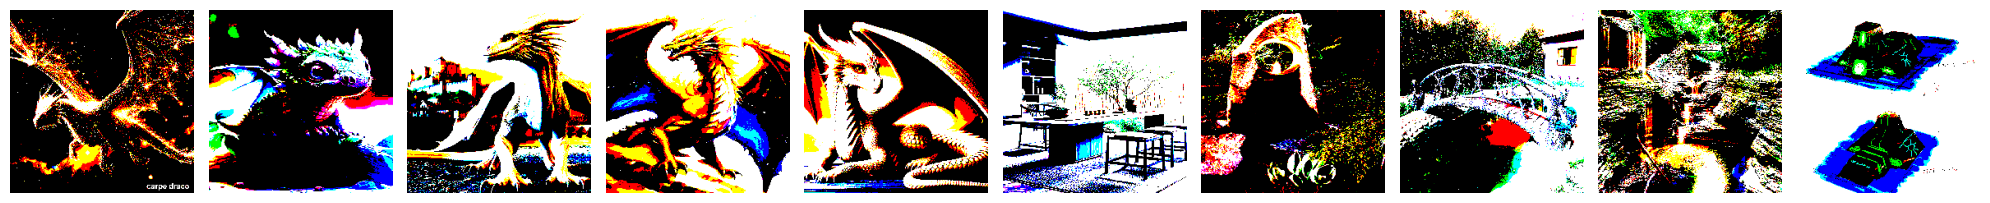

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [23]:
test_imgs, test_labels = next(test_batches)
def plotImages(images_arr):
  fix, axis = plt.subplots(1, 10, figsize=(20,20))
  axis = axis.flatten()
  for img, ax in zip(images_arr, axis):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

plotImages(test_imgs)
print(test_labels)


In [24]:
test_batches.classes

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1], dtype=int32)

In [25]:
predictions = model.predict(x=test_batches, verbose=0)

In [26]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [27]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

Confusion matrix, without normalization
[[5 0]
 [0 5]]


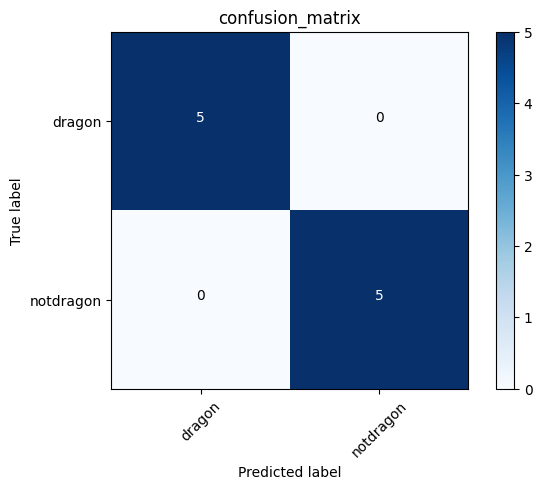

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

test_batches.class_indices
cm_plot_labels = [ 'dragon', 'notdragon']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='confusion_matrix')

In [ ]:
os.chdir(root_path)
model.save("dragon-model.tf", overwrite=True)

INFO:tensorflow:Assets written to: dragon-model.tf/assets


INFO:tensorflow:Assets written to: dragon-model.tf/assets


dragon-model.tf/assets/
dragon-model.tf/config.json
dragon-model.tf/fingerprint.pb
dragon-model.tf/keras_metadata.pb
dragon-model.tf/saved_model.pb
dragon-model.tf/variables/
dragon-model.tf/variables/variables.data-00000-of-00001
dragon-model.tf/variables/variables.index


In [30]:
import json
model_config=model.get_config()
model_config_json = json.dumps(model_config, indent=2)
with open('dragon-model.tf/config.json', 'w') as json_file:
    json_file.write(model_config_json)
!tar cvfz dragon-model.tar.gz dragon-model.tf/*
!split -b 200m dragon-model.tar.gz dragon-model.tar.gz.part

In [37]:
from huggingface_hub import from_pretrained_keras

model_keras_downloaded = from_pretrained_keras("hadilq/dragon-notdragon")

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/803 [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

variables/variables.index:   0%|          | 0.00/2.50k [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/51.3k [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/290k [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/537M [00:00<?, ?B/s]

In [38]:
def printable_prediction(prediction):
    return "dragon" if prediction[0][0] >= 0.96 else "not-dragon"

os.chdir(root_path)
!rm -rf jim/dragon/predict
!mkdir -p jim/dragon/predict
os.chdir('jim/dragon/predict')

In [40]:
print("upload your image file to jim/dragon/predict directory, then set the filename below:")
filename = '1a0ebf2de360926d285283c8480bb1d9.jpg'

upload your image file to jim/dragon/predict directory, then set the filename below:


In [41]:
img = keras.preprocessing.image.load_img(root_path + '/jim/dragon/predict/' + filename, target_size=(224, 224))
x = keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = keras.applications.vgg16.preprocess_input(x)
  
    
prediction = model.predict(x)
print("original model:", filename, printable_prediction(prediction))
prediction = model_keras_downloaded.predict(x)
print("downloaded model:", filename, printable_prediction(prediction))

1/1 [==============================] - 0s 371ms/step
original model: 1a0ebf2de360926d285283c8480bb1d9.jpg not-dragon
1/1 [==============================] - 0s 296ms/step
downloaded model: 1a0ebf2de360926d285283c8480bb1d9.jpg not-dragon


In [33]:
from huggingface_hub import notebook_login
notebook_login()

In [36]:
from huggingface_hub import push_to_hub_keras
push_to_hub_keras(
    model = model,
    repo_id = "hadilq/dragon-notdragon",
    commit_message = "push to huggingface hug",
    tags = ["dragon-detection", "Keras", "dragon", "image classification"]
)

INFO:tensorflow:Assets written to: /tmp/tmp7llzsd90/hadilq/dragon-notdragon/assets


INFO:tensorflow:Assets written to: /tmp/tmp7llzsd90/hadilq/dragon-notdragon/assets


keras_metadata.pb:   0%|          | 0.00/51.3k [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/537M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

fingerprint.pb:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/290k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/hadilq/dragon-notdragon/commit/1f866106e2e66e1dbcee36347450a946353328e3', commit_message='push to huggingface hug', commit_description='', oid='1f866106e2e66e1dbcee36347450a946353328e3', pr_url=None, pr_revision=None, pr_num=None)